In [1]:
!pip install torchsummary

In [2]:
!pip install tqdm

배치32

learning_rate = 0.001
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)


기존 
weight_decay = 0

변경
weight_decay = 0.001

In [3]:
import glob
import cv2
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import Subset
from torch.utils.tensorboard import SummaryWriter

import torchvision.models as models

from torchsummary import summary

import albumentations as A
from albumentations.pytorch import ToTensorV2

import numpy as np
import xml.etree.ElementTree as ET

from copy import deepcopy

from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [5]:
root_dir = '/kaggle/input/stanford-dogs-dataset'
img_dir = '/images/Images/'
annot_dir = '/annotations/Annotation/'

In [6]:
import os

labels_map = {}
for i, item in enumerate(os.listdir(root_dir + img_dir)):
    sub_folder = os.path.join(root_dir + img_dir, item)
    labels_map[sub_folder.split('-', maxsplit=3)[-1]] = i

In [7]:
def img_crop(annot_path, img):
    tree = ET.parse(annot_path)
    obj = tree.find('./object')
    bndbox = obj.find('bndbox')

    # 강아지 종류
    species = obj.find('name').text

    # 이미지에서의 강아지 위치
    xmin = int(bndbox.find('xmin').text)
    ymin = int(bndbox.find('ymin').text)
    xmax = int(bndbox.find('xmax').text)
    ymax = int(bndbox.find('ymax').text)

    cropped_img = img[ymin:ymax, xmin:xmax]
    
    label = labels_map.get(species)

    return label, cropped_img

In [8]:
class DogsDataset(Dataset):
    def __init__(self, annot_dir, img_dir, transform=None):
        annot_dir = glob.glob(root_dir + annot_dir + '*/*')
        img_dir = glob.glob(root_dir + img_dir + '*/*.jpg')
        self.annot_dir = sorted(annot_dir)
        self.img_dir = sorted(img_dir)
        
        self.transform = transform
        
    def __len__(self):
        return len(self.img_dir)
        
    def __getitem__(self, idx):
        annot_path = self.annot_dir[idx]
        img_path = self.img_dir[idx]
        
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        label, img = img_crop(annot_path, img)
        if self.transform is not None:
            img = self.transform(image=img)
            img['label'] = label
            return img

        sample = {'image': img, 'label': label}
        return sample

In [9]:
transformer = A.Compose([
    A.Resize(224, 224), 
    A.Normalize(), 
    ToTensorV2()
])

In [10]:
total_dataset = DogsDataset(annot_dir=annot_dir,
                           img_dir=img_dir,
                           transform=transformer)

In [11]:
total_label = [data['label'] for data in tqdm(total_dataset)]

trainset_idx, testset_idx = train_test_split(range(len(total_dataset)),
                test_size=0.2, random_state=42, shuffle=True, stratify=total_label)

100%|██████████| 20580/20580 [01:42<00:00, 200.54it/s]


In [12]:
train_set_ = Subset(total_dataset, trainset_idx)

train_label = [data['label'] for data in tqdm(train_set_)]

trainset_idx, validset_idx = train_test_split(range(len(trainset_idx)),
                test_size=0.2, random_state=42, shuffle=True, stratify=train_label)

100%|██████████| 16464/16464 [01:21<00:00, 203.18it/s]


In [13]:
train_set = Subset(train_set_, trainset_idx)
test_set = Subset(total_dataset, testset_idx)
valid_set = Subset(train_set_, validset_idx)

# 시각화

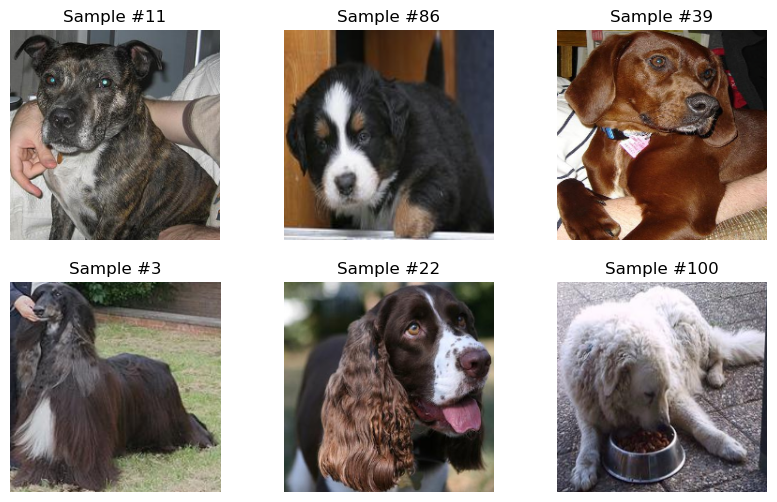

In [14]:
figure, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))
axes = axes.flatten()

for i in range(6):
    rand_i = np.random.randint(0, len(total_dataset))
    sample = total_dataset[rand_i]
    image = sample['image'].permute(1, 2, 0)
    label = sample['label']
    
    mean=torch.tensor([0.485, 0.456, 0.406]) 
    std=torch.tensor([0.229, 0.224, 0.225])
    image.mul_(std)
    image.add_(mean)
    
    axes[i].axis('off')
    axes[i].imshow(image)
    axes[i].set_title('Sample #{}'.format(label))

# 데이터 적재

In [15]:
batch_size = 32
trainloader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
validloader = DataLoader(valid_set, batch_size=batch_size, shuffle=False)
testloader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [16]:
train_iter = iter(trainloader)
batch = next(train_iter)
batch['image'].size(), len(batch['label'])

(torch.Size([32, 3, 224, 224]), 32)

# 모델 생성

In [17]:
model = models.resnet101(weights=models.ResNet101_Weights.DEFAULT)

Downloading: "https://download.pytorch.org/models/resnet101-cd907fc2.pth" to /root/.cache/torch/hub/checkpoints/resnet101-cd907fc2.pth


  0%|          | 0.00/171M [00:00<?, ?B/s]

In [18]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## 모델 변경

In [19]:
model.fc = nn.Linear(in_features=2048, out_features=120, bias=True)

In [20]:
for parameter in model.parameters():
    parameter.requires_grad = False

In [21]:
for parameter in model.fc.parameters():
    parameter.requires_grad=True

In [22]:
for parameter in model.parameters():
    print(parameter.requires_grad)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fals

In [23]:
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [24]:
out = model(batch['image'].to(device))
out.shape

torch.Size([32, 120])

In [26]:
learning_rate = 0.001
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

In [27]:
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [28]:
def validate(model, validloader, loss_fn):
    total = 0   
    correct = 0
    valid_loss = 0
    valid_accuracy = 0

  
    with torch.no_grad():
        for batch in validloader:
            images=batch['image'].to(device)
            labels=batch['label']
            labels = torch.Tensor(labels).to(device)

            logit = model(images) 
            _, preds = torch.max(logit, 1)
            correct += int((preds == labels).sum())
            total += labels.shape[0]

            loss = loss_fn(logit, labels)
            valid_loss += loss.item()

        valid_accuracy = correct / total
  
    return valid_loss, valid_accuracy

In [29]:
def train_loop(model, trainloader, loss_fn, epochs, optimizer):
    steps = 0
    steps_per_epoch = len(trainloader)
    min_loss = np.inf
    max_accuracy = -np.inf
    trigger = 0
    p = 10
    save_loss = np.inf

    for epoch in range(epochs):
        model.train()
        train_loss = 0

        for batch in tqdm(trainloader):
            images=batch['image'].to(device)
            labels=batch['label']
            labels = torch.Tensor(labels).to(device)
            
            steps+=1
                      
            predict = model(images)
            loss = loss_fn(predict, labels)

            optimizer.zero_grad()
            loss.backward()

            optimizer.step()

            train_loss += loss.item()

            if (steps % steps_per_epoch) == 0:
                model.eval()
                valid_loss, valid_accuracy = validate(model, validloader, loss_fn)    
                
                print('Epoch : {}/{}.......'.format(epoch+1, epochs),            
                    'Train Loss : {:.3f}'.format(train_loss/len(trainloader)), 
                    'Valid Loss : {:.3f}'.format(valid_loss/len(validloader)), 
                    'Valid Accuracy : {:.3f}'.format(valid_accuracy))

                if (valid_loss < save_loss) and (valid_accuracy >= max_accuracy):
                    save_loss = valid_loss
                    print('save ckpt')
                    min_loss = valid_loss
                    max_accuracy = valid_accuracy

                    best_model = deepcopy(model)
                    torch.save(best_model.state_dict(), 'best_ckpt_transfer_res101_batch32_wd.pth')

                
                # --- early stopping --- #
                if valid_loss > min_loss:
                    print('----trigger----', trigger+1)
                    trigger += 1
                    if trigger > p:
                        print('Early Stopping')
                        print('training loop is finished')
                        return 
                else:
                    trigger = 0
                    min_loss = valid_loss
                    
                scheduler.step(valid_loss)


In [30]:
epochs = 150
%time train_loop(model, trainloader, loss_fn, epochs, optimizer)

100%|█████████▉| 411/412 [01:44<00:00,  3.84it/s]

Epoch : 1/150....... Train Loss : 1.929 Valid Loss : 0.902 Valid Accuracy : 0.813
save ckpt


100%|█████████▉| 411/412 [01:47<00:00,  4.06it/s]

Epoch : 2/150....... Train Loss : 0.647 Valid Loss : 0.700 Valid Accuracy : 0.829
save ckpt


100%|█████████▉| 411/412 [01:44<00:00,  3.91it/s]

Epoch : 3/150....... Train Loss : 0.469 Valid Loss : 0.616 Valid Accuracy : 0.839
save ckpt


100%|█████████▉| 411/412 [01:43<00:00,  2.97it/s]

Epoch : 4/150....... Train Loss : 0.392 Valid Loss : 0.602 Valid Accuracy : 0.842
save ckpt


100%|██████████| 412/412 [02:27<00:00,  2.80it/s]


Epoch : 5/150....... Train Loss : 0.343 Valid Loss : 0.613 Valid Accuracy : 0.837
----trigger---- 1


100%|█████████▉| 411/412 [01:44<00:00,  3.99it/s]

Epoch : 6/150....... Train Loss : 0.312 Valid Loss : 0.575 Valid Accuracy : 0.848
save ckpt


100%|██████████| 412/412 [02:11<00:00,  3.12it/s]


Epoch : 7/150....... Train Loss : 0.291 Valid Loss : 0.575 Valid Accuracy : 0.842


100%|██████████| 412/412 [02:09<00:00,  3.18it/s]


Epoch : 8/150....... Train Loss : 0.273 Valid Loss : 0.569 Valid Accuracy : 0.845


100%|██████████| 412/412 [02:10<00:00,  3.15it/s]


Epoch : 9/150....... Train Loss : 0.265 Valid Loss : 0.572 Valid Accuracy : 0.841
----trigger---- 1


100%|█████████▉| 411/412 [01:43<00:00,  4.00it/s]

Epoch : 10/150....... Train Loss : 0.253 Valid Loss : 0.545 Valid Accuracy : 0.851
save ckpt


100%|██████████| 412/412 [02:11<00:00,  3.14it/s]


Epoch : 11/150....... Train Loss : 0.252 Valid Loss : 0.561 Valid Accuracy : 0.846
----trigger---- 1


100%|██████████| 412/412 [02:10<00:00,  3.16it/s]


Epoch : 12/150....... Train Loss : 0.244 Valid Loss : 0.538 Valid Accuracy : 0.848


100%|██████████| 412/412 [02:09<00:00,  3.18it/s]


Epoch : 13/150....... Train Loss : 0.241 Valid Loss : 0.549 Valid Accuracy : 0.848
----trigger---- 1


100%|██████████| 412/412 [02:09<00:00,  3.19it/s]


Epoch : 14/150....... Train Loss : 0.242 Valid Loss : 0.531 Valid Accuracy : 0.850


100%|██████████| 412/412 [02:09<00:00,  3.18it/s]


Epoch : 15/150....... Train Loss : 0.235 Valid Loss : 0.546 Valid Accuracy : 0.851
----trigger---- 1


100%|██████████| 412/412 [02:09<00:00,  3.18it/s]


Epoch : 16/150....... Train Loss : 0.229 Valid Loss : 0.548 Valid Accuracy : 0.849
----trigger---- 2


100%|██████████| 412/412 [02:27<00:00,  2.79it/s]


Epoch : 17/150....... Train Loss : 0.232 Valid Loss : 0.554 Valid Accuracy : 0.848
----trigger---- 3


100%|█████████▉| 411/412 [01:43<00:00,  3.87it/s]

Epoch : 18/150....... Train Loss : 0.228 Valid Loss : 0.545 Valid Accuracy : 0.853
save ckpt


100%|██████████| 412/412 [02:09<00:00,  3.17it/s]


Epoch 00018: reducing learning rate of group 0 to 5.0000e-04.


100%|██████████| 412/412 [02:08<00:00,  3.20it/s]


Epoch : 19/150....... Train Loss : 0.189 Valid Loss : 0.529 Valid Accuracy : 0.851


100%|█████████▉| 411/412 [01:43<00:00,  4.01it/s]

Epoch : 20/150....... Train Loss : 0.183 Valid Loss : 0.503 Valid Accuracy : 0.854
save ckpt


100%|██████████| 412/412 [02:09<00:00,  3.17it/s]


Epoch : 21/150....... Train Loss : 0.194 Valid Loss : 0.520 Valid Accuracy : 0.852
----trigger---- 1


100%|██████████| 412/412 [02:08<00:00,  3.20it/s]


Epoch : 22/150....... Train Loss : 0.194 Valid Loss : 0.510 Valid Accuracy : 0.856
----trigger---- 2


100%|█████████▉| 411/412 [01:43<00:00,  4.07it/s]

Epoch : 23/150....... Train Loss : 0.194 Valid Loss : 0.495 Valid Accuracy : 0.860
save ckpt


100%|██████████| 412/412 [02:09<00:00,  3.19it/s]


Epoch : 24/150....... Train Loss : 0.196 Valid Loss : 0.521 Valid Accuracy : 0.855
----trigger---- 1


100%|██████████| 412/412 [02:08<00:00,  3.20it/s]


Epoch : 25/150....... Train Loss : 0.195 Valid Loss : 0.523 Valid Accuracy : 0.850
----trigger---- 2


100%|█████████▉| 411/412 [01:43<00:00,  4.18it/s]

Epoch : 26/150....... Train Loss : 0.197 Valid Loss : 0.493 Valid Accuracy : 0.861
save ckpt


100%|██████████| 412/412 [02:09<00:00,  3.18it/s]


Epoch : 27/150....... Train Loss : 0.193 Valid Loss : 0.509 Valid Accuracy : 0.858
----trigger---- 1


100%|██████████| 412/412 [02:09<00:00,  3.18it/s]


Epoch : 28/150....... Train Loss : 0.195 Valid Loss : 0.518 Valid Accuracy : 0.851
----trigger---- 2


100%|██████████| 412/412 [02:09<00:00,  3.18it/s]


Epoch : 29/150....... Train Loss : 0.196 Valid Loss : 0.540 Valid Accuracy : 0.849
----trigger---- 3


100%|██████████| 412/412 [02:11<00:00,  3.14it/s]


Epoch : 30/150....... Train Loss : 0.198 Valid Loss : 0.512 Valid Accuracy : 0.852
----trigger---- 4
Epoch 00030: reducing learning rate of group 0 to 2.5000e-04.


100%|██████████| 412/412 [02:13<00:00,  3.08it/s]


Epoch : 31/150....... Train Loss : 0.182 Valid Loss : 0.499 Valid Accuracy : 0.861
----trigger---- 5


100%|█████████▉| 411/412 [01:45<00:00,  3.81it/s]

Epoch : 32/150....... Train Loss : 0.180 Valid Loss : 0.483 Valid Accuracy : 0.863
save ckpt


100%|██████████| 412/412 [02:13<00:00,  3.08it/s]


Epoch : 33/150....... Train Loss : 0.176 Valid Loss : 0.499 Valid Accuracy : 0.856
----trigger---- 1


100%|██████████| 412/412 [02:16<00:00,  3.01it/s]


Epoch : 34/150....... Train Loss : 0.179 Valid Loss : 0.501 Valid Accuracy : 0.858
----trigger---- 2


100%|██████████| 412/412 [02:11<00:00,  3.14it/s]


Epoch : 35/150....... Train Loss : 0.180 Valid Loss : 0.506 Valid Accuracy : 0.856
----trigger---- 3


100%|██████████| 412/412 [02:10<00:00,  3.16it/s]


Epoch : 36/150....... Train Loss : 0.180 Valid Loss : 0.522 Valid Accuracy : 0.853
----trigger---- 4
Epoch 00036: reducing learning rate of group 0 to 1.2500e-04.


100%|██████████| 412/412 [02:12<00:00,  3.10it/s]


Epoch : 37/150....... Train Loss : 0.173 Valid Loss : 0.492 Valid Accuracy : 0.857
----trigger---- 5


100%|██████████| 412/412 [02:13<00:00,  3.08it/s]


Epoch : 38/150....... Train Loss : 0.172 Valid Loss : 0.514 Valid Accuracy : 0.855
----trigger---- 6


100%|██████████| 412/412 [02:11<00:00,  3.14it/s]


Epoch : 39/150....... Train Loss : 0.172 Valid Loss : 0.493 Valid Accuracy : 0.862
----trigger---- 7


100%|██████████| 412/412 [02:12<00:00,  3.12it/s]


Epoch : 40/150....... Train Loss : 0.171 Valid Loss : 0.481 Valid Accuracy : 0.862


100%|█████████▉| 411/412 [01:46<00:00,  4.09it/s]

Epoch : 41/150....... Train Loss : 0.174 Valid Loss : 0.483 Valid Accuracy : 0.865
save ckpt


100%|██████████| 412/412 [02:10<00:00,  3.16it/s]


Epoch : 42/150....... Train Loss : 0.173 Valid Loss : 0.485 Valid Accuracy : 0.862
----trigger---- 1


100%|██████████| 412/412 [02:09<00:00,  3.17it/s]


Epoch : 43/150....... Train Loss : 0.173 Valid Loss : 0.485 Valid Accuracy : 0.862
----trigger---- 2


100%|██████████| 412/412 [02:09<00:00,  3.17it/s]


Epoch : 44/150....... Train Loss : 0.175 Valid Loss : 0.486 Valid Accuracy : 0.863
----trigger---- 3
Epoch 00044: reducing learning rate of group 0 to 6.2500e-05.


100%|██████████| 412/412 [02:12<00:00,  3.11it/s]


Epoch : 45/150....... Train Loss : 0.168 Valid Loss : 0.502 Valid Accuracy : 0.861
----trigger---- 4


100%|██████████| 412/412 [02:11<00:00,  3.14it/s]


Epoch : 46/150....... Train Loss : 0.170 Valid Loss : 0.491 Valid Accuracy : 0.859
----trigger---- 5


100%|██████████| 412/412 [02:10<00:00,  3.17it/s]


Epoch : 47/150....... Train Loss : 0.172 Valid Loss : 0.497 Valid Accuracy : 0.858
----trigger---- 6


100%|██████████| 412/412 [02:10<00:00,  3.15it/s]


Epoch : 48/150....... Train Loss : 0.172 Valid Loss : 0.495 Valid Accuracy : 0.863
----trigger---- 7
Epoch 00048: reducing learning rate of group 0 to 3.1250e-05.


100%|██████████| 412/412 [02:10<00:00,  3.16it/s]


Epoch : 49/150....... Train Loss : 0.168 Valid Loss : 0.487 Valid Accuracy : 0.862
----trigger---- 8


100%|██████████| 412/412 [02:09<00:00,  3.17it/s]


Epoch : 50/150....... Train Loss : 0.168 Valid Loss : 0.496 Valid Accuracy : 0.860
----trigger---- 9


100%|██████████| 412/412 [02:09<00:00,  3.17it/s]


Epoch : 51/150....... Train Loss : 0.168 Valid Loss : 0.496 Valid Accuracy : 0.861
----trigger---- 10


100%|██████████| 412/412 [02:12<00:00,  3.12it/s]


Epoch : 52/150....... Train Loss : 0.165 Valid Loss : 0.478 Valid Accuracy : 0.862


100%|█████████▉| 411/412 [01:45<00:00,  4.18it/s]

Epoch : 53/150....... Train Loss : 0.167 Valid Loss : 0.480 Valid Accuracy : 0.868
save ckpt


100%|██████████| 412/412 [02:11<00:00,  3.13it/s]


Epoch : 54/150....... Train Loss : 0.170 Valid Loss : 0.496 Valid Accuracy : 0.862
----trigger---- 1


100%|██████████| 412/412 [02:13<00:00,  3.08it/s]


Epoch : 55/150....... Train Loss : 0.170 Valid Loss : 0.510 Valid Accuracy : 0.854
----trigger---- 2


100%|██████████| 412/412 [02:12<00:00,  3.10it/s]


Epoch : 56/150....... Train Loss : 0.166 Valid Loss : 0.493 Valid Accuracy : 0.860
----trigger---- 3
Epoch 00056: reducing learning rate of group 0 to 1.5625e-05.


100%|██████████| 412/412 [02:12<00:00,  3.10it/s]


Epoch : 57/150....... Train Loss : 0.165 Valid Loss : 0.485 Valid Accuracy : 0.863
----trigger---- 4


100%|██████████| 412/412 [02:14<00:00,  3.07it/s]


Epoch : 58/150....... Train Loss : 0.166 Valid Loss : 0.525 Valid Accuracy : 0.852
----trigger---- 5


100%|██████████| 412/412 [02:11<00:00,  3.14it/s]


Epoch : 59/150....... Train Loss : 0.166 Valid Loss : 0.486 Valid Accuracy : 0.864
----trigger---- 6


100%|██████████| 412/412 [02:11<00:00,  3.12it/s]


Epoch : 60/150....... Train Loss : 0.166 Valid Loss : 0.508 Valid Accuracy : 0.857
----trigger---- 7
Epoch 00060: reducing learning rate of group 0 to 7.8125e-06.


100%|██████████| 412/412 [02:13<00:00,  3.09it/s]


Epoch : 61/150....... Train Loss : 0.164 Valid Loss : 0.494 Valid Accuracy : 0.863
----trigger---- 8


100%|██████████| 412/412 [02:14<00:00,  3.07it/s]


Epoch : 62/150....... Train Loss : 0.164 Valid Loss : 0.471 Valid Accuracy : 0.867


100%|██████████| 412/412 [02:13<00:00,  3.08it/s]


Epoch : 63/150....... Train Loss : 0.167 Valid Loss : 0.493 Valid Accuracy : 0.860
----trigger---- 1


100%|██████████| 412/412 [02:11<00:00,  3.12it/s]


Epoch : 64/150....... Train Loss : 0.166 Valid Loss : 0.502 Valid Accuracy : 0.858
----trigger---- 2


100%|██████████| 412/412 [02:11<00:00,  3.13it/s]


Epoch : 65/150....... Train Loss : 0.166 Valid Loss : 0.497 Valid Accuracy : 0.862
----trigger---- 3


100%|█████████▉| 411/412 [01:46<00:00,  3.92it/s]

Epoch : 66/150....... Train Loss : 0.166 Valid Loss : 0.472 Valid Accuracy : 0.869
save ckpt


100%|██████████| 412/412 [02:12<00:00,  3.10it/s]


Epoch 00066: reducing learning rate of group 0 to 3.9063e-06.


100%|██████████| 412/412 [02:11<00:00,  3.12it/s]


Epoch : 67/150....... Train Loss : 0.168 Valid Loss : 0.487 Valid Accuracy : 0.863
----trigger---- 1


100%|██████████| 412/412 [02:12<00:00,  3.12it/s]


Epoch : 68/150....... Train Loss : 0.166 Valid Loss : 0.486 Valid Accuracy : 0.861
----trigger---- 2


100%|██████████| 412/412 [02:11<00:00,  3.13it/s]


Epoch : 69/150....... Train Loss : 0.169 Valid Loss : 0.486 Valid Accuracy : 0.862
----trigger---- 3


100%|██████████| 412/412 [02:12<00:00,  3.10it/s]


Epoch : 70/150....... Train Loss : 0.166 Valid Loss : 0.502 Valid Accuracy : 0.858
----trigger---- 4
Epoch 00070: reducing learning rate of group 0 to 1.9531e-06.


100%|██████████| 412/412 [02:11<00:00,  3.12it/s]


Epoch : 71/150....... Train Loss : 0.167 Valid Loss : 0.490 Valid Accuracy : 0.862
----trigger---- 5


100%|██████████| 412/412 [02:13<00:00,  3.09it/s]


Epoch : 72/150....... Train Loss : 0.164 Valid Loss : 0.489 Valid Accuracy : 0.865
----trigger---- 6


100%|██████████| 412/412 [02:16<00:00,  3.03it/s]


Epoch : 73/150....... Train Loss : 0.165 Valid Loss : 0.491 Valid Accuracy : 0.859
----trigger---- 7


100%|██████████| 412/412 [02:18<00:00,  2.98it/s]


Epoch : 74/150....... Train Loss : 0.168 Valid Loss : 0.499 Valid Accuracy : 0.856
----trigger---- 8
Epoch 00074: reducing learning rate of group 0 to 9.7656e-07.


100%|██████████| 412/412 [02:14<00:00,  3.07it/s]


Epoch : 75/150....... Train Loss : 0.164 Valid Loss : 0.505 Valid Accuracy : 0.862
----trigger---- 9


100%|██████████| 412/412 [02:11<00:00,  3.14it/s]


Epoch : 76/150....... Train Loss : 0.165 Valid Loss : 0.475 Valid Accuracy : 0.868
----trigger---- 10


100%|█████████▉| 411/412 [02:09<00:00,  3.16it/s]

Epoch : 77/150....... Train Loss : 0.164 Valid Loss : 0.499 Valid Accuracy : 0.862
----trigger---- 11
Early Stopping
training loop is finished
CPU times: user 2h 38min 19s, sys: 17min 20s, total: 2h 55min 40s
Wall time: 2h 49min 16s


# 모델 예측

In [32]:
test_iter = iter(testloader)

batch = next(test_iter)

images, labels = batch['image'].to(device), batch['label'].to(device)
print(images.size(), labels.size())

rnd_idx = 3
print(images[rnd_idx].shape, labels[rnd_idx])

torch.Size([32, 3, 224, 224]) torch.Size([32])
torch.Size([3, 224, 224]) tensor(47, device='cuda:0')


In [33]:
model.eval()
with torch.no_grad():
    logit = model(images[rnd_idx].unsqueeze(0))
pred = logit.max(dim=1)[1]
print(pred == labels[rnd_idx])

tensor([True], device='cuda:0')


pred: tensor([47], device='cuda:0') labels: tensor(47, device='cuda:0')
torch.Size([224, 224, 3])


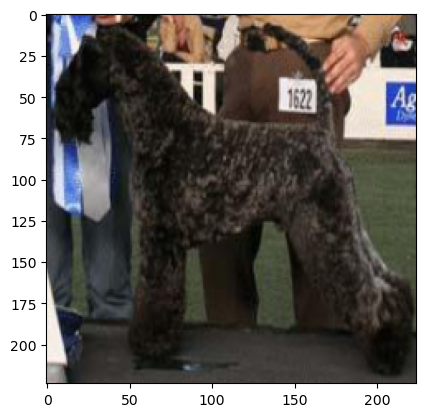

In [34]:
print("pred:", pred, "labels:", labels[rnd_idx])

images = images[rnd_idx].permute(1, 2, 0).cpu()
mean=torch.tensor([0.485, 0.456, 0.406]) 
std=torch.tensor([0.229, 0.224, 0.225])
images.mul_(std)
images.add_(mean)
print(images.shape)
plt.imshow(images)

In [35]:
def evaluation(model, testloader, loss_fn):
    total = 0   
    correct = 0
    test_loss = 0
    test_accuracy = 0

    with torch.no_grad():
        for batch in tqdm(testloader):
            images, labels = batch['image'].to(device), batch['label'].to(device)

            logit = model(images)
            _, preds = torch.max(logit, 1)

            correct += int((preds == labels).sum())
            total += labels.shape[0]

            loss = loss_fn(logit, labels)
            test_loss += loss.item()
            
        test_accuracy = correct / total
   
        print('Test Loss : {:.3f}'.format(test_loss/len(testloader)), 
            'Test Accuracy : {:.3f}'.format(test_accuracy))

model.eval()
evaluation(model, testloader, loss_fn)  

100%|██████████| 129/129 [00:39<00:00,  3.25it/s]

Test Loss : 0.501 Test Accuracy : 0.859


# 모델 저장

In [36]:
torch.save(model.state_dict(), 'last_ckpt_transfer_res101_batch32_wd.pth')

In [37]:
last_state_dict = torch.load('last_ckpt_transfer_res101_batch32_wd.pth')

In [38]:
last_model = models.resnet101(weights=models.ResNet101_Weights.DEFAULT)
last_model.fc = nn.Linear(in_features=2048, out_features=120)
last_model.to(device)
last_model.get_parameter = last_model.load_state_dict(last_state_dict)

In [39]:
last_model.eval()
evaluation(last_model, testloader, loss_fn)  

100%|██████████| 129/129 [00:32<00:00,  3.93it/s]

Test Loss : 0.501 Test Accuracy : 0.859


In [40]:
best_state_dict = torch.load('best_ckpt_transfer_res101_batch32_wd.pth')

In [41]:
best_model = models.resnet101(weights=models.ResNet101_Weights.DEFAULT)
best_model.fc = nn.Linear(in_features=2048, out_features=120)
best_model.to(device)
best_model.get_parameter = best_model.load_state_dict(best_state_dict)

In [42]:
best_model.eval()
evaluation(best_model, testloader, loss_fn)

100%|██████████| 129/129 [00:32<00:00,  3.98it/s]

Test Loss : 0.479 Test Accuracy : 0.865
